In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.signal import find_peaks
from statistics import mean, quantiles, stdev, variance
from scipy.stats import pearsonr, kurtosis, skew
import seaborn as sns

def RMS(x,y,z): # root mean square
    from statistics import sqrt
    lst = list()
    for i in range(len(x)):
        powered = (x[i]**2+y[i]**2+z[i]**2)/3
        lst.append(sqrt(powered))
    return lst

def norm(x,y,z):
    lengths = [len(x),len(y),len(z)]
    assert lengths[0]==lengths[1],' x and y must have the same length {}!={}'.format(lengths[0], lengths[1])
    assert lengths[0]==lengths[2],' x and z must have the same length {}!={}'.format(lengths[0], lengths[2])
    concat = np.vstack([x,y,z]).transpose() # Transpose to get (n, 3)
    assert concat.shape[0]==lengths[0], 'Make sure that x,y,z are list of scalars'
    #print(sum(concat[0]**2), np.sum(concat[0]**2,axis=1))
    normed = np.sqrt(np.sum(concat**2, axis=1))
    return normed


def norm_hor_vert(y,z):
    lengths = [len(y),len(z)]
    assert lengths[0]==lengths[1],' x and y must have the same length {}!={}'.format(lengths[0], lengths[1])
    concat = np.vstack([y,z]).transpose()
    normed_hor = np.sqrt(np.sum(concat**2, axis=1))
    normed_vert = abs(z.values)
    return normed_hor, normed_vert


def plotting_acc(df):

    time = df['Time [s]']
    g = 9.81
    x_acc = df[' Acceleration_x [m/s^2]']/g
    y_acc = df[' Acceleration_y [m/s^2]']/g
    z_acc = df[' Acceleration_z [m/s^2]']/g


    normed_acc = norm(x_acc,y_acc,z_acc)
    time = df['Time [s]']

    plt.figure()
    plt.title('Acceleration_x [m/s^2]')
    plt.plot(time,x_acc)
    plt.figure()
    plt.title('Acceleration_y [m/s^2]')
    plt.plot(time,y_acc)
    plt.figure()
    plt.title('Acceleration_z [m/s^2]')
    plt.plot(time,z_acc)
    plt.figure()
    plt.title('Normed Acceleration [m/s^2]')
    plt.plot(time,normed_acc)

    return normed_acc


def total_sum(df):

    time = df['Time [s]']

    x_acc = df[' Acceleration_x [m/s^2]']/9.81
    y_acc = df[' Acceleration_y [m/s^2]']/9.81
    z_acc = df[' Acceleration_z [m/s^2]']/9.81

    s = abs(x_acc) + abs(y_acc) + abs(z_acc)

    plt.figure()
    plt.title('Total Acceleration [m/s^2]')
    plt.plot(time,s)


def plotting_vel(df):

    time = df['Time [s]']

    x_vel = df[' Angular-velocity_x [Deg/s]']
    y_vel = df[' Angular-velocity_y [Deg/s]']
    z_vel = df[' Angular-velocity_z [Deg/s]']

    normed_vel = norm(x_vel,y_vel,z_vel)
   
    time = df['Time [s]']

    plt.figure()
    plt.title('Angular-velocity_x [Deg/s]')
    plt.plot(time,x_vel)
    plt.figure()
    plt.title('Angular-velocity_y [Deg/s]')
    plt.plot(time,y_vel)
    plt.figure()
    plt.title('Angular-velocity_z [Deg/s]')
    plt.plot(time,z_vel)
    plt.figure()
    plt.title('Normed Angular-velocity [Deg/s]')
    plt.plot(time,normed_vel)
    return normed_vel


def cutting(df,fig):

    #################################### creating new raw features ####################
    time = df['Time [s]']
    g = 9.81
    x_acc = df[' Acceleration_x [m/s^2]']/g
    y_acc = df[' Acceleration_y [m/s^2]']/g
    z_acc = df[' Acceleration_z [m/s^2]']/g

    x_vel = df[' Angular-velocity_x [Deg/s]']
    y_vel = df[' Angular-velocity_y [Deg/s]']
    z_vel = df[' Angular-velocity_z [Deg/s]']

    normed_vel = norm(x_vel,y_vel,z_vel)
    normed_vel = pd.DataFrame(normed_vel, columns=['Normed Angular-velocity [Deg/s]'])

    normed_acc = norm(x_acc,y_acc,z_acc)
    normed_acc = pd.DataFrame(normed_acc, columns=['Normed Acceleration [m/s^2]'])

    normed_hor, normed_vert = norm_hor_vert(y_acc,z_acc)
    normed_vert = pd.DataFrame(normed_vert, columns=['Vertical Acceleration [m/s^2]'])
    normed_hor = pd.DataFrame(normed_hor, columns=['Horizontal Acceleration [m/s^2]'])
    

    acc = pd.concat([x_acc, y_acc, z_acc, normed_acc, normed_hor, normed_vert], axis=1)
    raw = pd.concat([x_vel, y_vel, z_vel, normed_vel], axis=1)
    if ' Euler-pitch [Deg]' in df.columns:
        euler = df[[' Euler-yaw [Deg]', ' Euler-roll [Deg]', ' Euler-pitch [Deg]']]
        quanternion = df[[ ' Quaternion_w []', ' Quaternion_x []', ' Quaternion_y []', ' Quaternion_z []']]
    else:
        euler = pd.DataFrame(np.zeros((len(normed_vel), 3)), columns= [' Euler-yaw [Deg]', ' Euler-roll [Deg]', ' Euler-pitch [Deg]'])
        quanternion = pd.DataFrame(np.zeros((len(normed_vel), 4)), columns= [' Quaternion_w []', ' Quaternion_x []', ' Quaternion_y []', ' Quaternion_z []'])


    acc_raw = pd.concat([acc, raw], axis=1)
    acc_euler =pd.concat([acc, euler], axis=1)
    acc_quan = pd.concat([acc, quanternion], axis=1)

    acc_raw_euler_quan = pd.concat([acc, raw, euler, quanternion], axis=1) # use this!

    normed_vel_avg = normed_vel.rolling(200, center=True).mean()


    ##################################### finding peaks ################################
    
    data = [x for x in normed_vel_avg['Normed Angular-velocity [Deg/s]']]

    #find peaks based on highes normed angular velocity
    peaks, _ = find_peaks(data, prominence=200)
    peaks2, _ = find_peaks(data, distance=15000)

    # nested list contains indexes which are important to cut out the point of interest
    # 500 and 400 define the timewindow which fits all points of interest
    cuts = [[i-500,i+400] for i in peaks] 

    #################################### creating features #############################
    features = list()
    figur = int(fig)
    for i in range(len(cuts)):
  
        feature_cut = list()
        feature_cut.append(figur)
        cut = acc_raw_euler_quan.loc[cuts[i][0]:cuts[i][1]]
        for col in cut.columns:
            feature_cut.append(mean(cut[col]))
            feature_cut.append(min(cut[col]))
            feature_cut.append(max(cut[col]))
            feature_cut.append(max(cut[col]) - min(cut[col]))
            feature_cut.extend([x for x in quantiles(cut[col], n=4)])
            feature_cut.append(stdev(cut[col]))
            feature_cut.append(variance(cut[col]))
            feature_cut.append(kurtosis(cut[col]))
            feature_cut.append(skew(cut[col]))
            if col == 'Vertical Acceleration [m/s^2]':
                feature_cut.extend([x for x in pearsonr(cut['Horizontal Acceleration [m/s^2]'], cut['Vertical Acceleration [m/s^2]'])])
        features.append(feature_cut)

    ################### creating pandas cloumns for features + mearing them ############

    columns = list()
    columns.append('Figur')
    for col in acc_raw_euler_quan.columns:
        columns.append(col+' '+'Mean')
        columns.append(col+' '+'Min')
        columns.append(col+' '+'Max')
        columns.append(col+' '+'Variation')
        columns.append(col+' '+'First Quartile')
        columns.append(col+' '+'Second Quartile // Median')
        columns.append(col+' '+'Third Quartile')
        columns.append(col+' '+'Standard Dev')
        columns.append(col+' '+'Variance')
        columns.append(col+' '+'Kurtosis')
        columns.append(col+' '+'Skeweness')
        if col == 'Vertical Acceleration [m/s^2]':
            columns.append('Corr Vert & Hor')
            columns.append('P-Val')

    features = pd.DataFrame(features, columns=columns)

    
    return df, cuts, features


Loading the data and using predefinded functions to create features from sequential data

+ creating a 3x4 subplot of all figures for axis of interest

0_B5_QE.csv
0_D14_QE.csv
0_D5_QE.csv
0_J2_QE.csv
0_J5_QE.csv
1_B4.csv
1_B4_QE.csv
1_J2.csv
1_J2_QE.csv
1_J5_QE.csv
1_L5.csv
2_J2_QE.csv
2_J4.csv
2_J5_QE.csv
2_L4.csv
2_M7.csv
2_Y4_QE.csv
3_M2.csv


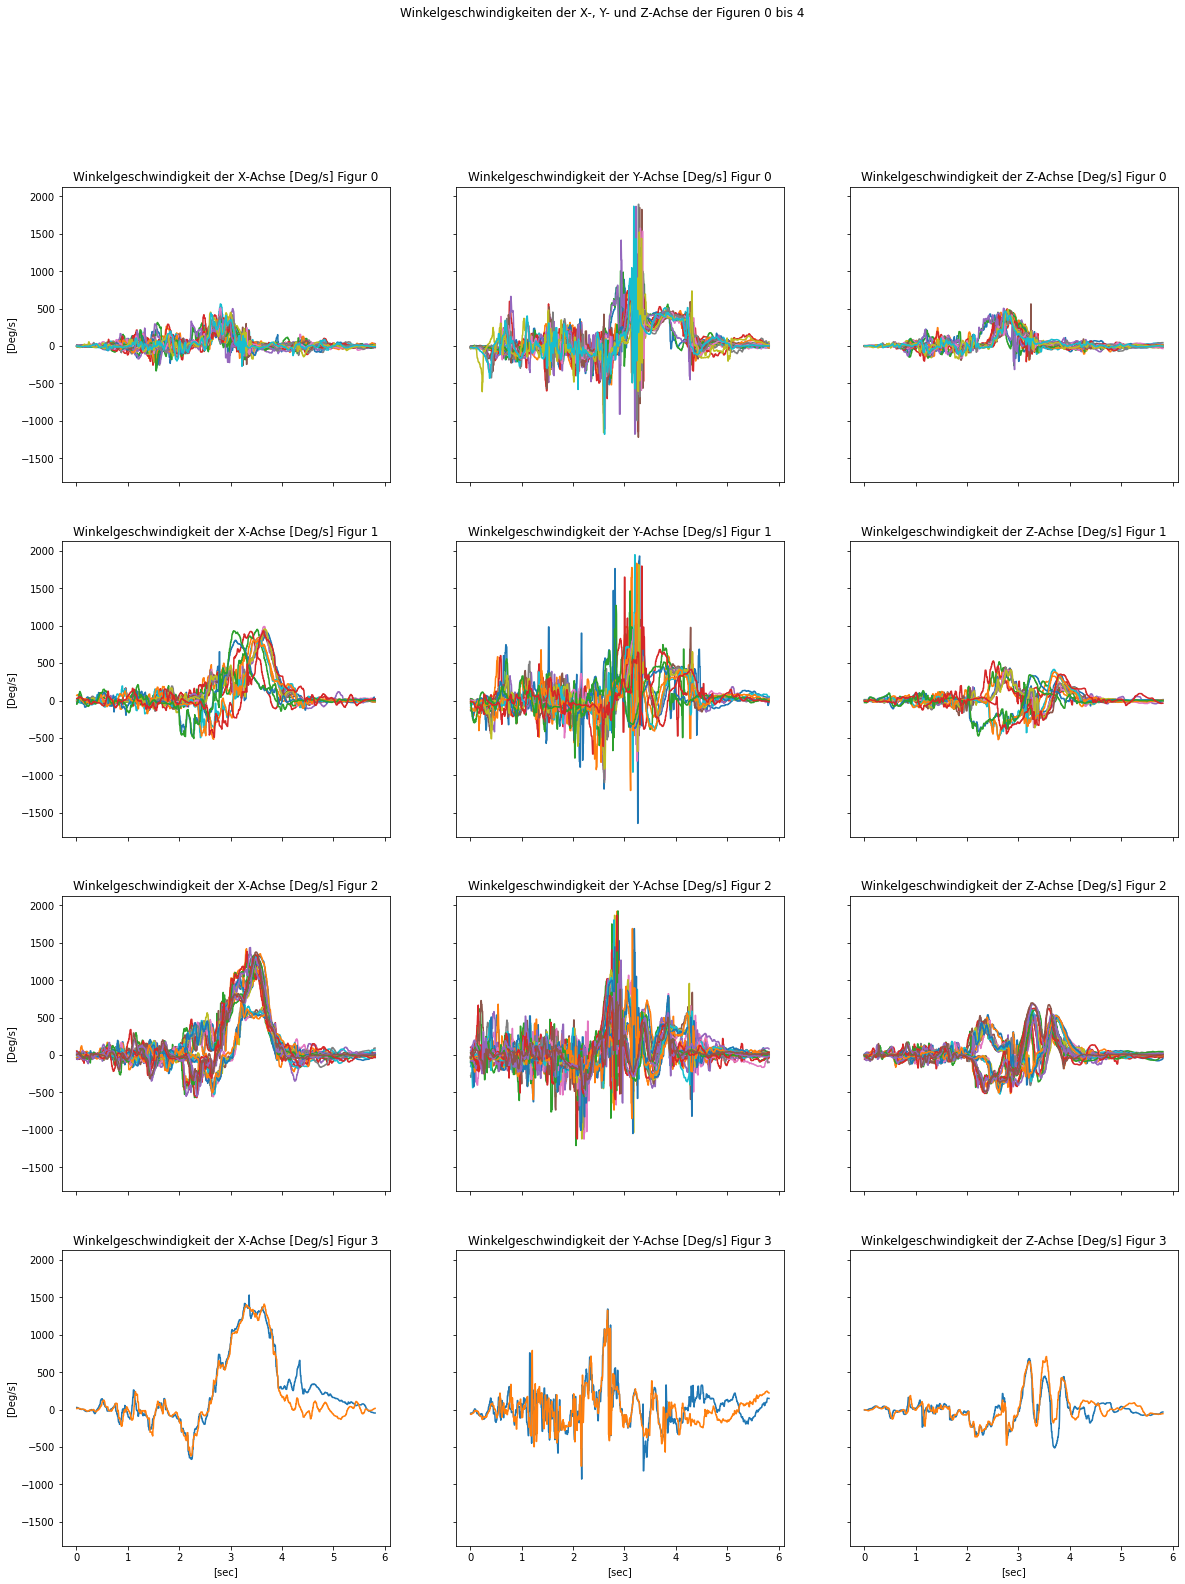

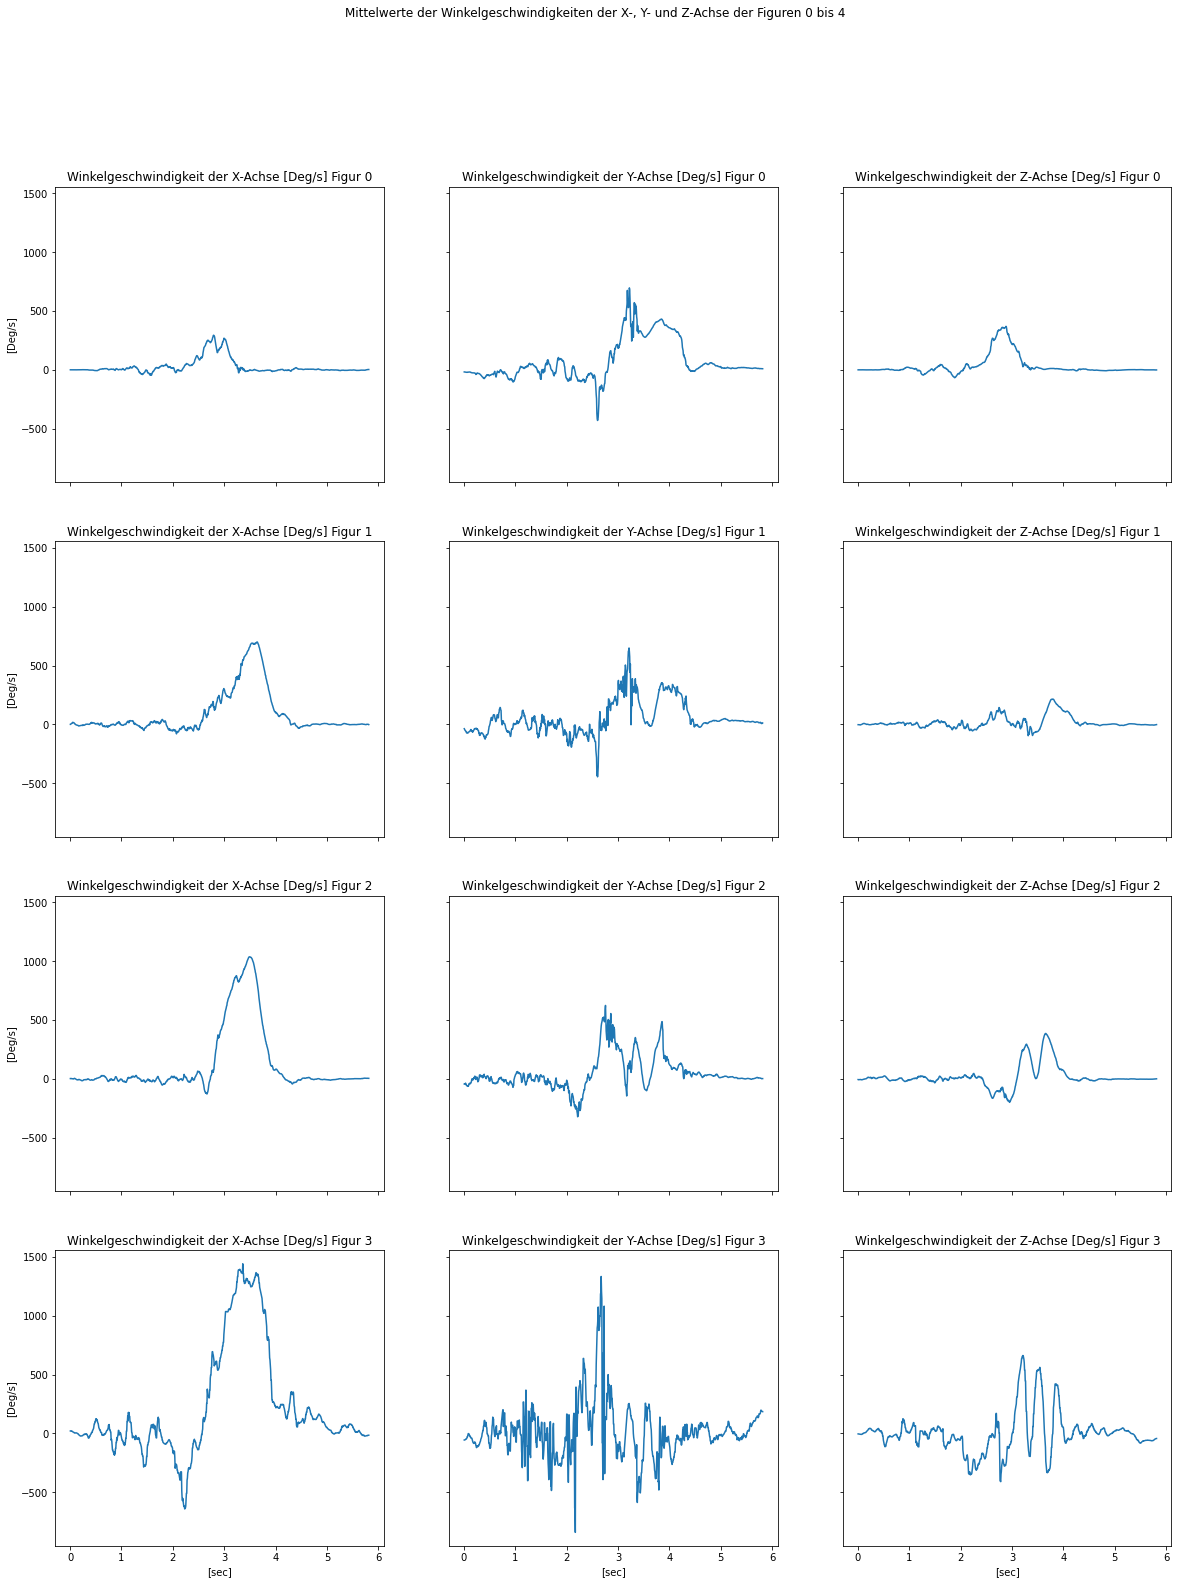

In [2]:
root = os.getcwd()+'/'         # 'D:/BiVital_Data/turnen/' #
files = os.listdir(root)
files = files[1::]
files = files[:(len(files)-1)]
all_data = pd.DataFrame()

len_files = len(files)-1

data2plot_0_x = pd.DataFrame()
data2plot_0_y = pd.DataFrame()
data2plot_0_z = pd.DataFrame()

data2plot_1_x = pd.DataFrame()
data2plot_1_y = pd.DataFrame()
data2plot_1_z = pd.DataFrame()

data2plot_2_x = pd.DataFrame()
data2plot_2_y = pd.DataFrame()
data2plot_2_z = pd.DataFrame()

data2plot_3_x = pd.DataFrame()
data2plot_3_y = pd.DataFrame()
data2plot_3_z = pd.DataFrame()

xaxis = [x/155 for x in range(1,902)] # time = samplefrequency/samplerate // timewindow is 901 ticks long

# define subplot
figure, axs = plt.subplots(4, 3, figsize=(20,25), sharex=True, sharey=True)
figure.suptitle('Winkelgeschwindigkeiten der X-, Y- und Z-Achse der Figuren 0 bis 4')

for file in files:
    
    print(file)

    if file!= 'BiVit_classifier.ipynb' or file != '.git':
        
        fig = file.split('_')[0]
        figB = file.split('_')[1]
         
        raw_data = pd.read_csv(root+file, header=1)

        df, cuts, features = cutting(raw_data,fig)
        
        if fig == '0':
            for cut in cuts:
                data2plot = raw_data.loc[cut[0]:cut[1]]
                data2plot = data2plot.reset_index(drop=True)

                data2plot_0_x = pd.concat([data2plot_0_x, data2plot[' Angular-velocity_x [Deg/s]']], axis=1)
                data2plot_0_y = pd.concat([data2plot_0_y, data2plot[' Angular-velocity_y [Deg/s]']], axis=1)
                data2plot_0_z = pd.concat([data2plot_0_z, data2plot[' Angular-velocity_z [Deg/s]']], axis=1)

                axs[0, 0].plot(xaxis,data2plot[' Angular-velocity_x [Deg/s]'])
                axs[0, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 0')
                axs[0, 1].plot(xaxis, data2plot[' Angular-velocity_y [Deg/s]'])
                axs[0, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 0')
                axs[0, 2].plot(xaxis, data2plot[' Angular-velocity_z [Deg/s]'])
                axs[0, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 0')

        # Figur 1
        if fig == '1' and 'B' not in figB: # filtering out twists around right side
            for cut in cuts:
                data2plot = raw_data.loc[cut[0]:cut[1]]
                data2plot = data2plot.reset_index(drop=True)

                data2plot_1_x = pd.concat([data2plot_1_x, data2plot[' Angular-velocity_x [Deg/s]']], axis=1)
                data2plot_1_y = pd.concat([data2plot_1_y, data2plot[' Angular-velocity_y [Deg/s]']], axis=1)
                data2plot_1_z = pd.concat([data2plot_1_z, data2plot[' Angular-velocity_z [Deg/s]']], axis=1)

                axs[1, 0].plot(xaxis,data2plot[' Angular-velocity_x [Deg/s]'])
                axs[1, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 1')
                axs[1, 1].plot(xaxis, data2plot[' Angular-velocity_y [Deg/s]'])
                axs[1, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 1')
                axs[1, 2].plot(xaxis, data2plot[' Angular-velocity_z [Deg/s]'])
                axs[1, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 1')
        
        # Figur 2
        if fig == '2':
            for cut in cuts:
                data2plot = raw_data.loc[cut[0]:cut[1]]
                data2plot = data2plot.reset_index(drop=True)

                data2plot_2_x = pd.concat([data2plot_2_x, data2plot[' Angular-velocity_x [Deg/s]']], axis=1)
                data2plot_2_y = pd.concat([data2plot_2_y, data2plot[' Angular-velocity_y [Deg/s]']], axis=1)
                data2plot_2_z = pd.concat([data2plot_2_z, data2plot[' Angular-velocity_z [Deg/s]']], axis=1)

                axs[2, 0].plot(xaxis,data2plot[' Angular-velocity_x [Deg/s]'])
                axs[2, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 2')
                axs[2, 1].plot(xaxis, data2plot[' Angular-velocity_y [Deg/s]'])
                axs[2, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 2')
                axs[2, 2].plot(xaxis, data2plot[' Angular-velocity_z [Deg/s]'])
                axs[2, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 2')

        # Figur 3
        if fig == '3':
            for cut in cuts:
                data2plot = raw_data.loc[cut[0]:cut[1]]
                data2plot = data2plot.reset_index(drop=True)

                data2plot_3_x = pd.concat([data2plot_3_x, data2plot[' Angular-velocity_x [Deg/s]']], axis=1)
                data2plot_3_y = pd.concat([data2plot_3_y, data2plot[' Angular-velocity_y [Deg/s]']], axis=1)
                data2plot_3_z = pd.concat([data2plot_3_z, data2plot[' Angular-velocity_z [Deg/s]']], axis=1)

                axs[3, 0].plot(xaxis, data2plot[' Angular-velocity_x [Deg/s]'])
                axs[3, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 3')
                axs[3, 1].plot(xaxis,data2plot[' Angular-velocity_y [Deg/s]'])
                axs[3, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 3')
                axs[3, 2].plot(xaxis, data2plot[' Angular-velocity_z [Deg/s]'])
                axs[3, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 3')

        for ax in axs.flat:
            ax.set(xlabel='[sec]', ylabel='[Deg/s]')

        for ax in axs.flat:
            ax.label_outer()


        one_block_features = features
        all_data = pd.concat([all_data, one_block_features])


mean_0_x = data2plot_0_x.mean(axis=1)
mean_0_y = data2plot_0_y.mean(axis=1)
mean_0_z = data2plot_0_z.mean(axis=1)

mean_1_x = data2plot_1_x.mean(axis=1)
mean_1_y = data2plot_1_y.mean(axis=1)
mean_1_z = data2plot_1_z.mean(axis=1)

mean_2_x = data2plot_2_x.mean(axis=1)
mean_2_y = data2plot_2_y.mean(axis=1)
mean_2_z = data2plot_2_z.mean(axis=1)

mean_3_x = data2plot_3_x.mean(axis=1)
mean_3_y = data2plot_3_y.mean(axis=1)
mean_3_z = data2plot_3_z.mean(axis=1)


figure, axs = plt.subplots(4, 3, figsize=(20,25), sharex=True, sharey=True)
figure.suptitle('Mittelwerte der Winkelgeschwindigkeiten der X-, Y- und Z-Achse der Figuren 0 bis 4')
axs[0, 0].plot(xaxis,mean_0_x)
axs[0, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 0')
axs[0, 1].plot(xaxis, mean_0_y)
axs[0, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 0')
axs[0, 2].plot(xaxis, mean_0_z)
axs[0, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 0')
axs[1, 0].plot(xaxis, mean_1_x)
axs[1, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 1')
axs[1, 1].plot(xaxis, mean_1_y)
axs[1, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 1')
axs[1, 2].plot(xaxis, mean_1_z)
axs[1, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 1')
axs[2, 0].plot(xaxis, mean_2_x)
axs[2, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 2')
axs[2, 1].plot(xaxis, mean_2_y)
axs[2, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 2')
axs[2, 2].plot(xaxis, mean_2_z)
axs[2, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 2')
axs[3, 0].plot(xaxis, mean_3_x)
axs[3, 0].set_title('Winkelgeschwindigkeit der X-Achse [Deg/s] Figur 3')
axs[3, 1].plot(xaxis, mean_3_y)
axs[3, 1].set_title('Winkelgeschwindigkeit der Y-Achse [Deg/s] Figur 3')
axs[3, 2].plot(xaxis, mean_3_z)
axs[3, 2].set_title('Winkelgeschwindigkeit der Z-Achse [Deg/s] Figur 3')

for ax in axs.flat:
    ax.set(xlabel='[sec]', ylabel='[Deg/s]')
    
for ax in axs.flat:
    ax.label_outer()

dall_data = all_data.reset_index(inplace = True, drop = True)

df_raw = all_data.loc[:, 'Figur':'Normed Angular-velocity [Deg/s] Skeweness']
df_euler = pd.concat([all_data.loc[:,'Figur':'P-Val'],all_data.loc[:,' Euler-yaw [Deg] Mean':' Euler-pitch [Deg] Skeweness']],axis=1)
df_quan = pd.concat([all_data.loc[:,'Figur':'P-Val'],all_data.loc[:,' Quaternion_w [] Mean':' Quaternion_z [] Skeweness']],axis=1)

df_euler = df_euler[df_euler[' Euler-yaw [Deg] Mean'] != 0].reset_index(drop = True)
df_quan = df_quan[df_quan[' Quaternion_w [] Mean'] != 0].reset_index(drop = True)

# Correlation matrix


In [3]:
col_drop = ['P-Val'] # 'Quartile','Variance','Dev','Min','Max','Variation', 'Kurtosis', 'Skeweness', ,'Horizontal','Vertical','Acc'
extracted = all_data
for c in col_drop:
    extracted = extracted[extracted.columns.drop(list(extracted.filter(regex=c)))]
print(type(extracted))
corr = extracted.corr()
corr.style.background_gradient(cmap='coolwarm')


<class 'pandas.core.frame.DataFrame'>


# Explorative data analysis

Data preprocessing:
MinMaxScaler / PCA

Classifiers used:
KNN / SVM / Gaussian Naive Bayes / Random Forest


Optimal value for K: 1
Best Score:  1.0
Accuracy: 1.0
Maximum accuracy: 1.0 at K = 1
[1.0, 1.0, 1.0]


c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


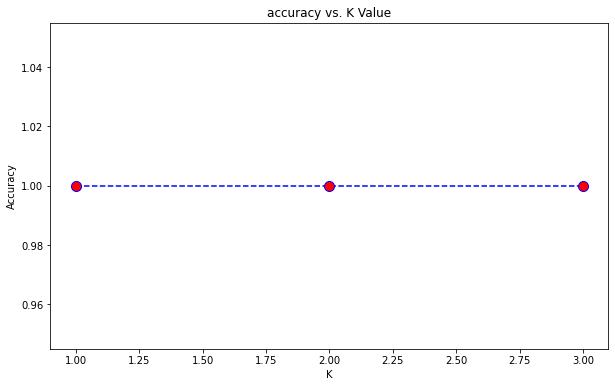

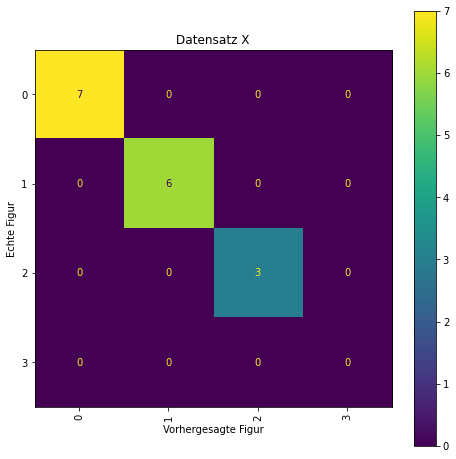

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

accuracy of the KNN is:  1.0
Optimal value for K: 3
Best Score:  0.95
Accuracy: 1.0
Maximum accuracy: 1.0 at K = 1
[1.0, 1.0, 1.0]


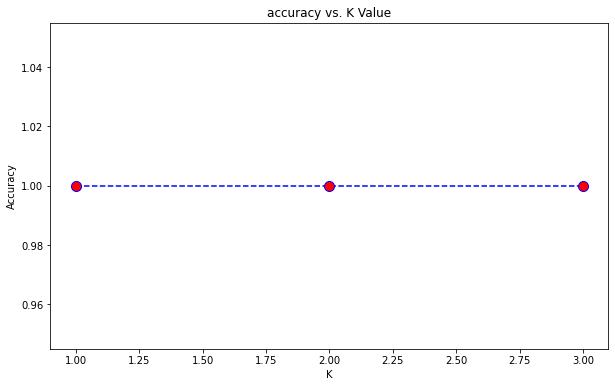

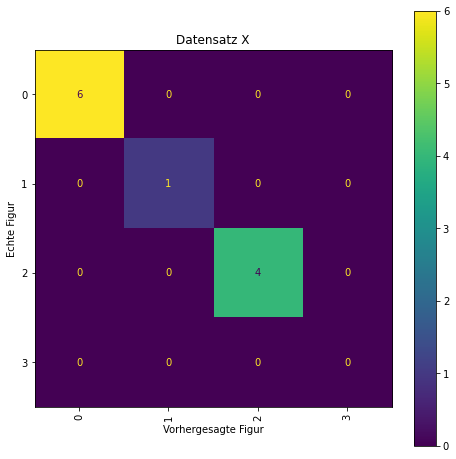

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the KNN is:  1.0
Optimal value for K: 1
Best Score:  1.0
Accuracy: 1.0
Maximum accuracy: 1.0 at K = 1
[1.0, 1.0, 1.0]


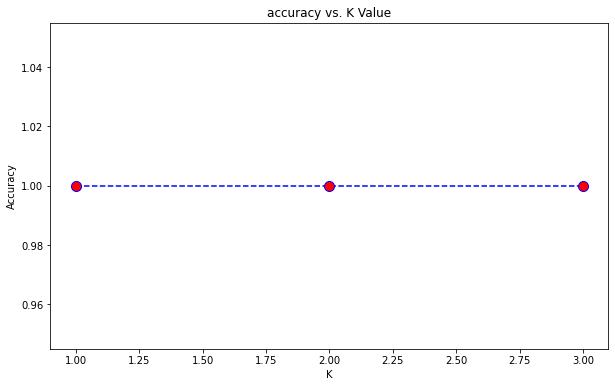

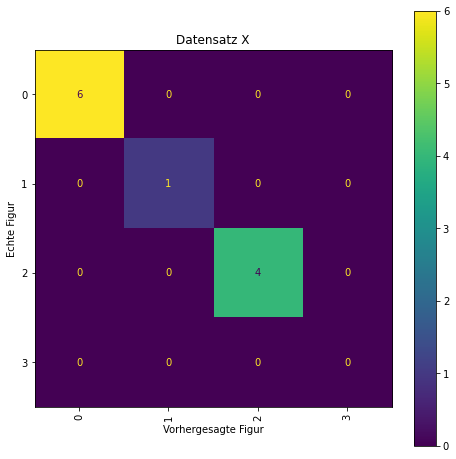

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the KNN is:  1.0
dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])


c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters:  {'C': 1, 'degree': 1, 'gamma': 1, 'kernel': 'rbf'}
Best Score:  1.0


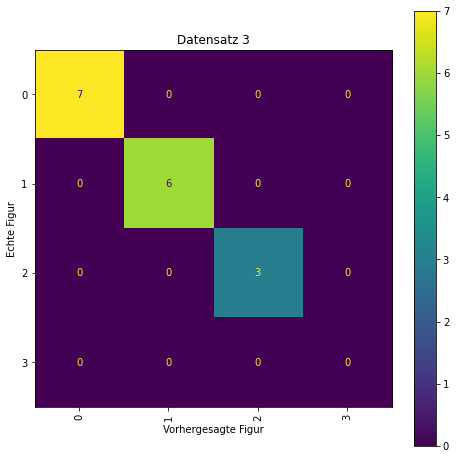

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

accuracy of the SVM is:  1.0
dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
Best Parameters:  {'C': 0.1, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best Score:  

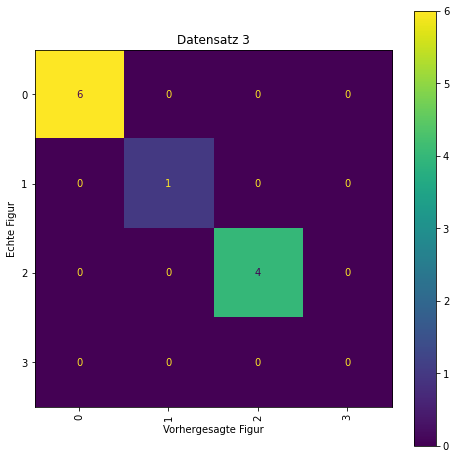

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the SVM is:  1.0
dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])
Best Parameters:  {'C': 0.1, 'degree': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best Score:  

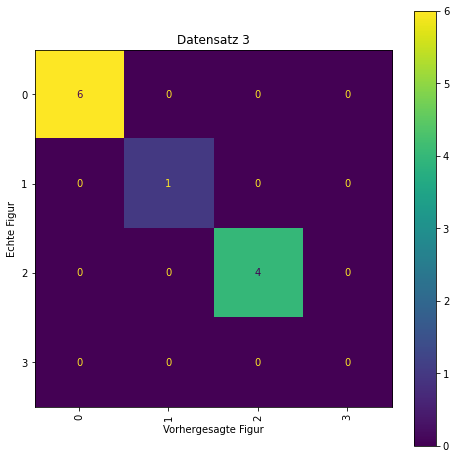

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the SVM is:  1.0


c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 200}
Model accuracy: 0.9384615384615385


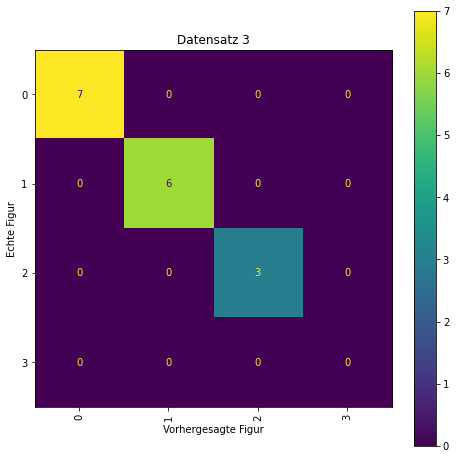

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         3

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

accuracy of the RF is:  1.0
Best hyperparameters: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 100}
Model accuracy: 1.0


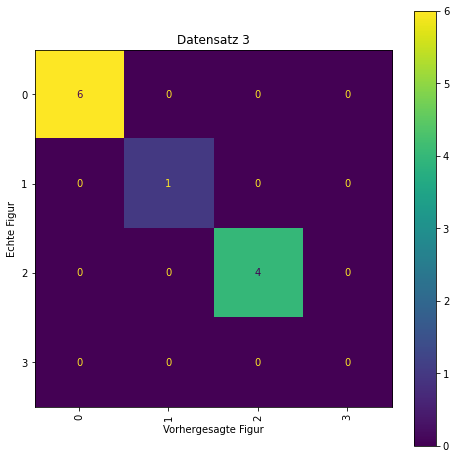

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the RF is:  1.0
Best hyperparameters: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Model accuracy: 1.0


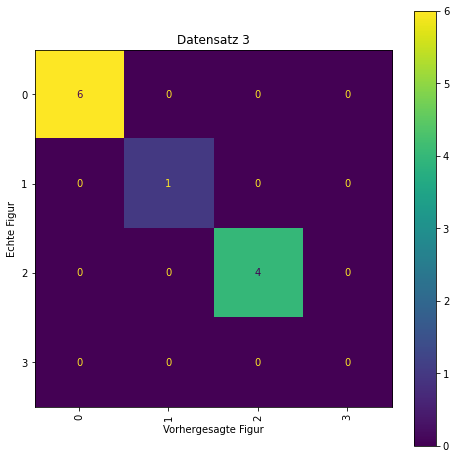

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the RF is:  1.0


c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best hyperparameters: {'var_smoothing': 0.2848035868435802}
Model accuracy: 0.9051282051282051


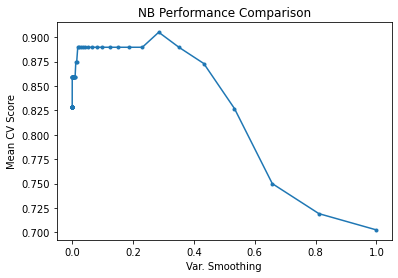

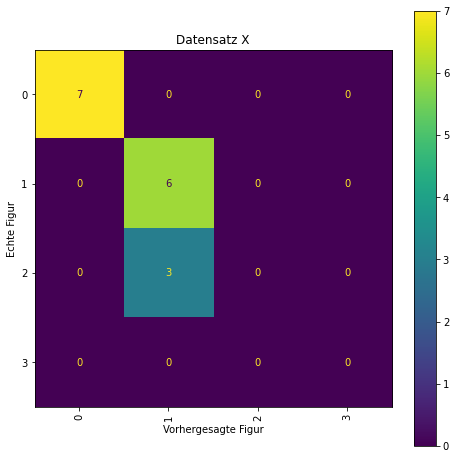

c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Justin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       0.67      1.00      0.80         6
           2       0.00      0.00      0.00         3

    accuracy                           0.81        16
   macro avg       0.56      0.67      0.60        16
weighted avg       0.69      0.81      0.74        16

accuracy of the Gaussian NB is:  0.8125
Best hyperparameters: {'var_smoothing': 0.1873817422860384}
Model accuracy: 1.0


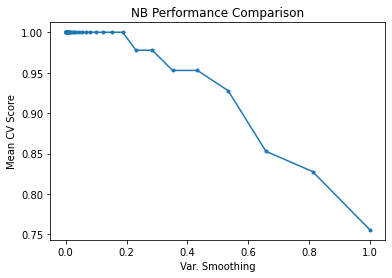

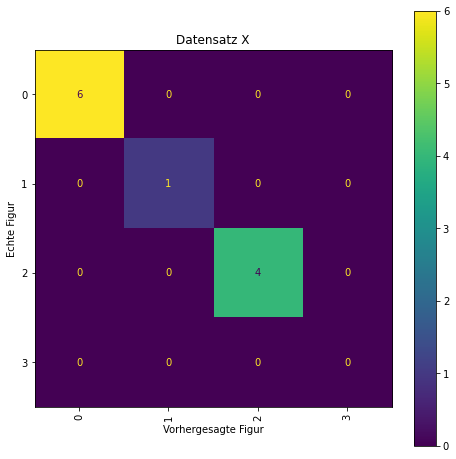

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the Gaussian NB is:  1.0
Best hyperparameters: {'var_smoothing': 0.533669923120631}
Model accuracy: 1.0


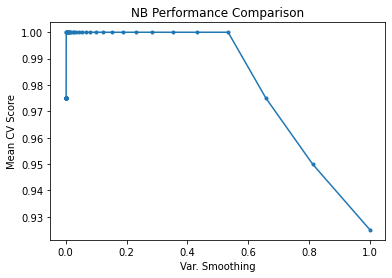

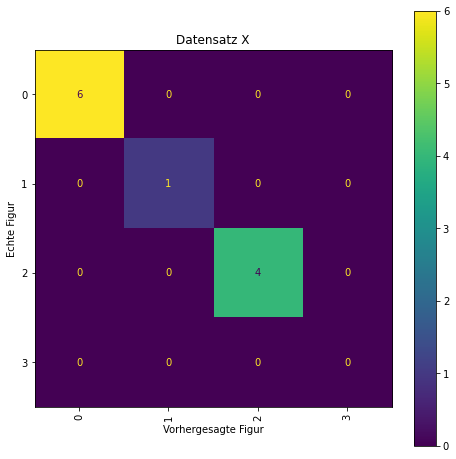

report:                precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         4

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11

accuracy of the Gaussian NB is:  1.0


GaussianNB(var_smoothing=0.533669923120631)

In [4]:
######################################## ML ########################################

#returns scaled and and demensionality reduced X_test and X_train data + normal y_train and y_test data
def t_t_split(df): 
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.decomposition import PCA


    y = df['Figur']
    X = df.drop(columns=['Figur'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    scaler.fit(X_train)
    scaled_X_train = scaler.transform(X_train)

    scaled_X_test = scaler.transform(X_test)

    pca = PCA(n_components=5)
    pca.fit(scaled_X_train)
    X_train_pca = pca.transform(scaled_X_train)


                        ####### used to find best Number of components######
                        # prop_var = pca.explained_variance_ratio_
                        
                        # PC_numbers = np.arange(pca.n_components_) + 1
                        
                        # plt.plot(PC_numbers, 
                        #         prop_var, 
                        #         'ro-')
                        # plt.title('Figure 1: Scree Plot', fontsize=8)
                        # plt.ylabel('Proportion of Variance', fontsize=8)
                        # plt.show()

    X_test_pca = pca.transform(scaled_X_test)

    return X_train_pca, X_test_pca, y_train, y_test, scaler, pca

X_train_raw, X_test_raw, y_train_raw, y_test_raw, _, _ = t_t_split(df_raw)
X_train_euler, X_test_euler, y_train_euler, y_test_euler, _, _ = t_t_split(df_euler)
X_train_quan, X_test_quan, y_train_quan, y_test_quan, _, _ = t_t_split(df_quan)


def KNN_prediction(X_train, X_test, y_train, y_test):
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
    from sklearn.preprocessing import MinMaxScaler, LabelEncoder

    knn = KNeighborsClassifier()
    param_grid = {'n_neighbors': [1,3,5], 'weights': ['uniform', 'distance']}

    grid_search = GridSearchCV(knn, param_grid=param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    
    optimal_k = grid_search.best_params_['n_neighbors']
    print('Optimal value for K:',optimal_k)
    print("Best Score: ", grid_search.best_score_)
    
    best_model = grid_search.best_estimator_
    knn = best_model

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    print('Accuracy:',accuracy)

    acc = []
    # Will take some time
    from sklearn import metrics
    for i in range(1,4): # K > n!
        neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
        yhat = neigh.predict(X_test)
        acc.append(metrics.accuracy_score(y_test, yhat))

    plt.figure(figsize=(10,6))
    plt.plot(range(1,4),acc,color = 'blue',linestyle='dashed', # K > n!
             marker='o',markerfacecolor='red', markersize=10)
    plt.title('accuracy vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    print("Maximum accuracy:",max(acc),"at K =",acc.index(max(acc))+1)
    print(acc)

    

    label_enc = LabelEncoder()
    label_enc.fit([0,1,2,3])

    cm = confusion_matrix(y_test, y_pred, labels=([0,1,2,3]))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_enc.classes_)
    fig, ax = plt.subplots(figsize=(8, 8))
    display.plot(ax=ax, xticks_rotation='vertical')
    display.ax_.set_xlabel("Vorhergesagte Figur")
    display.ax_.set_ylabel("Echte Figur")
    display.ax_.set_title('Datensatz X')
    plt.show()

    print('report: ', classification_report(y_test, y_pred))
    print('accuracy of the KNN is: ',accuracy_score(y_test, y_pred))
    
    return knn 



KNN_prediction(X_train_raw, X_test_raw, y_train_raw, y_test_raw)
KNN_prediction(X_train_euler, X_test_euler, y_train_euler, y_test_euler)
KNN_prediction(X_train_quan, X_test_quan, y_train_quan, y_test_quan)

def svm(X_train, X_test, y_train, y_test):
    from sklearn.svm import SVC
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
    from sklearn.preprocessing import LabelEncoder
    from sklearn.compose import make_column_transformer
    from sklearn.model_selection import train_test_split, GridSearchCV

    label_enc = LabelEncoder()
    label_enc.fit([0,1,2,3])

    params = {'C': [0.1,1,10], 'gamma':[0.1,1,10], 'kernel':['poly','linear','rbf'], 'degree': [1,2,3]}

    clf = SVC()

    grid_search = GridSearchCV(clf, param_grid=params, cv=5)
    print(grid_search.get_params().keys())
    grid_search.fit(X_train,y_train)

    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    best_model = grid_search.best_estimator_
    clf = best_model

    pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, pred, labels= [0, 1, 2, 3])

    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_enc.classes_)
    fig, ax = plt.subplots(figsize=(8, 8))
    display.plot(ax=ax, xticks_rotation='vertical')
    display.ax_.set_xlabel("Vorhergesagte Figur")
    display.ax_.set_ylabel("Echte Figur")
    display.ax_.set_title('Datensatz 3')
    plt.show()

    print('report: ', classification_report(y_test, pred))
    print('accuracy of the SVM is: ',accuracy_score(y_test, pred))

    return clf


svm(X_train_raw, X_test_raw, y_train_raw, y_test_raw)
svm(X_train_euler, X_test_euler, y_train_euler, y_test_euler)
svm(X_train_quan, X_test_quan, y_train_quan, y_test_quan)


def RandFor(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
    from sklearn.preprocessing import LabelEncoder

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [2, 4, 6],
        'min_samples_split': [2, 4, 6],
        'min_samples_leaf': [2, 3, 4]
    }

    clf = RandomForestClassifier()

    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
    grid_search.fit(X_train,y_train)


    print("Best hyperparameters:", grid_search.best_params_)
    print("Model accuracy:", grid_search.best_score_)

    best_rf_clf = grid_search.best_estimator_
    feature_importances = best_rf_clf.feature_importances_
    rf = best_rf_clf

    pred = rf.predict(X_test)

    label_enc = LabelEncoder()
    label_enc.fit([0,1,2,3])

    cm = confusion_matrix(y_test, pred, labels= [0, 1, 2, 3])

    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_enc.classes_)
    fig, ax = plt.subplots(figsize=(8, 8))
    display.plot(ax=ax, xticks_rotation='vertical')
    display.ax_.set_xlabel("Vorhergesagte Figur")
    display.ax_.set_ylabel("Echte Figur")
    display.ax_.set_title('Datensatz 3')
    plt.show()

    print('report: ', classification_report(y_test, pred))
    print('accuracy of the RF is: ',accuracy_score(y_test, pred))

    return rf

RandFor(X_train_raw, X_test_raw, y_train_raw, y_test_raw)
RandFor(X_train_euler, X_test_euler, y_train_euler, y_test_euler)
RandFor(X_train_quan, X_test_quan, y_train_quan, y_test_quan)


def GauNB(X_train, X_test, y_train, y_test):
    from sklearn.naive_bayes import GaussianNB # Only GNB classifier, because Categorial and Multinmial can not handle negative values
    from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
    from sklearn.preprocessing import LabelEncoder
    from sklearn.compose import make_column_transformer
    from sklearn.model_selection import GridSearchCV

    param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

    gnb = GaussianNB()

    grid_search = GridSearchCV(gnb, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    gnb = best_model

    print("Best hyperparameters:", grid_search.best_params_)
    print("Model accuracy:", grid_search.best_score_)
    # GNB.fit(transformed_X_train,y_train)
    pred = gnb.predict(X_test)

    
    results_NB = pd.DataFrame(grid_search.cv_results_['params'])
    results_NB['test_score'] = grid_search.cv_results_['mean_test_score']

    plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
    plt.xlabel('Var. Smoothing')
    plt.ylabel("Mean CV Score")
    plt.title("NB Performance Comparison")
    plt.show()

    # grid_search = GridSearchCV(GNB, param_grid, cv=5)
    # grid_search.fit(transformed_X_train, y_train)
    
    label_enc = LabelEncoder()
    label_enc.fit([0,1,2,3])

    cm = confusion_matrix(y_test, pred, labels=([0,1,2,3]))
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= label_enc.classes_)
    fig, ax = plt.subplots(figsize=(8, 8))
    display.plot(ax=ax, xticks_rotation='vertical')
    display.ax_.set_xlabel("Vorhergesagte Figur")
    display.ax_.set_ylabel("Echte Figur")
    display.ax_.set_title('Datensatz X')
    plt.show()

    print('report: ', classification_report(y_test, pred))
    print('accuracy of the Gaussian NB is: ',accuracy_score(y_test, pred))

    return gnb
    
GauNB(X_train_raw, X_test_raw, y_train_raw, y_test_raw)
GauNB(X_train_euler, X_test_euler, y_train_euler, y_test_euler)
GauNB(X_train_quan, X_test_quan, y_train_quan, y_test_quan)